## Todo
- eda midi file typ[e]
- first 30 seconds?
- add anomaly detection
- try some cross validation or other model effects (SVM)
- more features 
    - get time signature from meta messages
    - stdev of velocity (instead of just average)
    - create some manual cross variables with timing and key and time sig

## Initial Imports and Paths

In [1]:
import pandas as pd
import numpy as np
import os
# midi files
import mido

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# ml packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# file paths
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

print(os.listdir(train_midi_path))
print(os.listdir(test_midi_path))

['.DS_Store', 'Beethoven', 'Schubert', 'Bach', 'Brahms']
['0.8014751784512073_adj.mid', '0.981087291054314_adj.mid', '0.5807329043589801_adj.mid', '0.23120017256495873_adj.mid', '0.033313986422223163_adj.mid', '0.3559970176888735_adj.mid', '0.3264565808984162_adj.mid', '0.905499891236923_adj.mid', '0.10250888365879718_adj.mid', '0.48367685897240176_adj.mid', '0.549470161204349_adj.mid', '0.33695573887576447_adj.mid', '0.7491289879531658_adj.mid', '0.337517805339117_adj.mid', '0.07186746659481313_adj.mid', '0.09167358800381353_adj.mid', '0.539512676743813_adj.mid', '0.26551079719260606_adj.mid', '0.647959423719129_adj.mid', '0.047574444458241216_adj.mid', '0.10222964826466285_adj.mid', '0.22047111832936942_adj.mid', '0.1755252422917658_adj.mid', '0.36321860283443286_adj.mid', '0.21198476749665085_adj.mid', '0.06402123326764841_adj.mid', '0.3620067189216978_adj.mid', '0.9511403301279795_adj.mid', '0.1960551158929671_adj.mid', '0.21901852969811753_adj.mid', '0.10630249969742178_adj.mid', 

## Data Collection and Processing

In [3]:
def extract_features_from_midi(file_path):
    ## Input: file path of midi file
    ## Output: list [ticks per beat, key, average_velocity, note counts for 128 notes]

    # import file
    midi = mido.MidiFile(file_path)

    # initialize values
    note_counts = [0] * 128  # MIDI notes range from 0 to 127
    total_velocity = 0
    note_on_count = 0
    key = '' # each file should have only 1 key. Investigate if this assumption is correct.
    tpb = midi.ticks_per_beat

    # get ticks
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_counts[msg.note] += 1
                total_velocity += msg.velocity
                note_on_count += 1
            if msg.is_meta and msg.type == 'key_signature':
                key = msg.key
            
    # Calculate average velocity
    if note_on_count > 0:
        average_velocity = total_velocity / note_on_count
    else:
        average_velocity = 0
    
    # Normalize the note counts to be between 0 and 1
    normalized_note_counts = (note_counts - np.min(note_counts)) / (np.max(note_counts) - np.min(note_counts))
    
    # combine into 1 list
    combined_features = [tpb, key, average_velocity] + list(normalized_note_counts)

    return combined_features

In [4]:
def load_dataset(directory, labeled=True):
    features = []
    labels = []
    if labeled:
        for composer_dir in os.listdir(directory):
            composer_path = os.path.join(directory, composer_dir)
            if os.path.isdir(composer_path):
                for file_name in os.listdir(composer_path):
                    if file_name.endswith('.mid'):
                        file_path = os.path.join(composer_path, file_name)
                        features.append(extract_features_from_midi(file_path))
                        labels.append(composer_dir)
        return features, labels
    else:
        for file_name in os.listdir(directory):
            if file_name.endswith('.mid'):
                file_path = os.path.join(directory, file_name)
                features.append(extract_features_from_midi(file_path))
        return features

In [5]:
unlabeled_features = load_dataset(test_midi_path, labeled=False)

In [6]:
features, labels = load_dataset(train_midi_path, labeled=True)

## EDA

In [7]:
def create_dataframe(features, labels=[]):
    # Convert to pandas DataFrame
    feature_columns = ['tpb', 'key', 'average_velocity']+[f'Note_{i}' for i in range(128)]
    df = pd.DataFrame(features, columns=feature_columns)
    if len(labels)>0:
        df['composer'] = labels
    return df

df_labeled = create_dataframe(features, labels)
df_labeled.to_csv('eda_df.csv')
df_labeled.head()

,tpb,key,average_velocity,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,...,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127,composer
0,384,Cm,101.945073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
1,384,Dm,94.358557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
2,384,Eb,82.289295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
3,384,Cm,85.691959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
4,384,G,86.643597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven


In [8]:
df_unlabeled=create_dataframe(unlabeled_features)
df_unlabeled.head()

,tpb,key,average_velocity,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,...,Note_118,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127
0,192,F,80.629530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,Eb,70.631660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,120,C,69.991784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,384,A,86.471655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,384,Bm,99.968136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Display basic information about the DataFrame
print("\nBasic Information about the DataFrame:")
print(df_labeled.info())

# Generate summary statistics
print("\nSummary Statistics of the DataFrame:")
print(df_labeled.describe())

# Check for missing values
print("\nMissing Values in the DataFrame:")
print(df_labeled.isnull().sum())


Basic Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 132 entries, tpb to composer
dtypes: float64(129), int64(1), object(2)
memory usage: 200.2+ KB
None

Summary Statistics of the DataFrame:
               tpb  average_velocity  Note_0  Note_1  Note_2  Note_3  Note_4  \
count   194.000000        194.000000   194.0   194.0   194.0   194.0   194.0   
mean    349.567010         82.246621     0.0     0.0     0.0     0.0     0.0   
std     129.871112         13.565164     0.0     0.0     0.0     0.0     0.0   
min     120.000000         46.818713     0.0     0.0     0.0     0.0     0.0   
25%     384.000000         73.121036     0.0     0.0     0.0     0.0     0.0   
50%     384.000000         83.024333     0.0     0.0     0.0     0.0     0.0   
75%     384.000000         92.797942     0.0     0.0     0.0     0.0     0.0   
max    1024.000000        127.000000     0.0     0.0     0.0     0.0     0.0   

       Note_5  Note_

In [10]:
df_labeled.key.value_counts()

key
C      28
Eb     26
       16
G      15
F      15
Ab     15
Bb     14
E      14
A      12
D      10
Cm      8
Fm      5
Dm      4
Bm      3
Am      2
Db      2
Gm      1
Em      1
Abm     1
F#      1
Gb      1
Name: count, dtype: int64

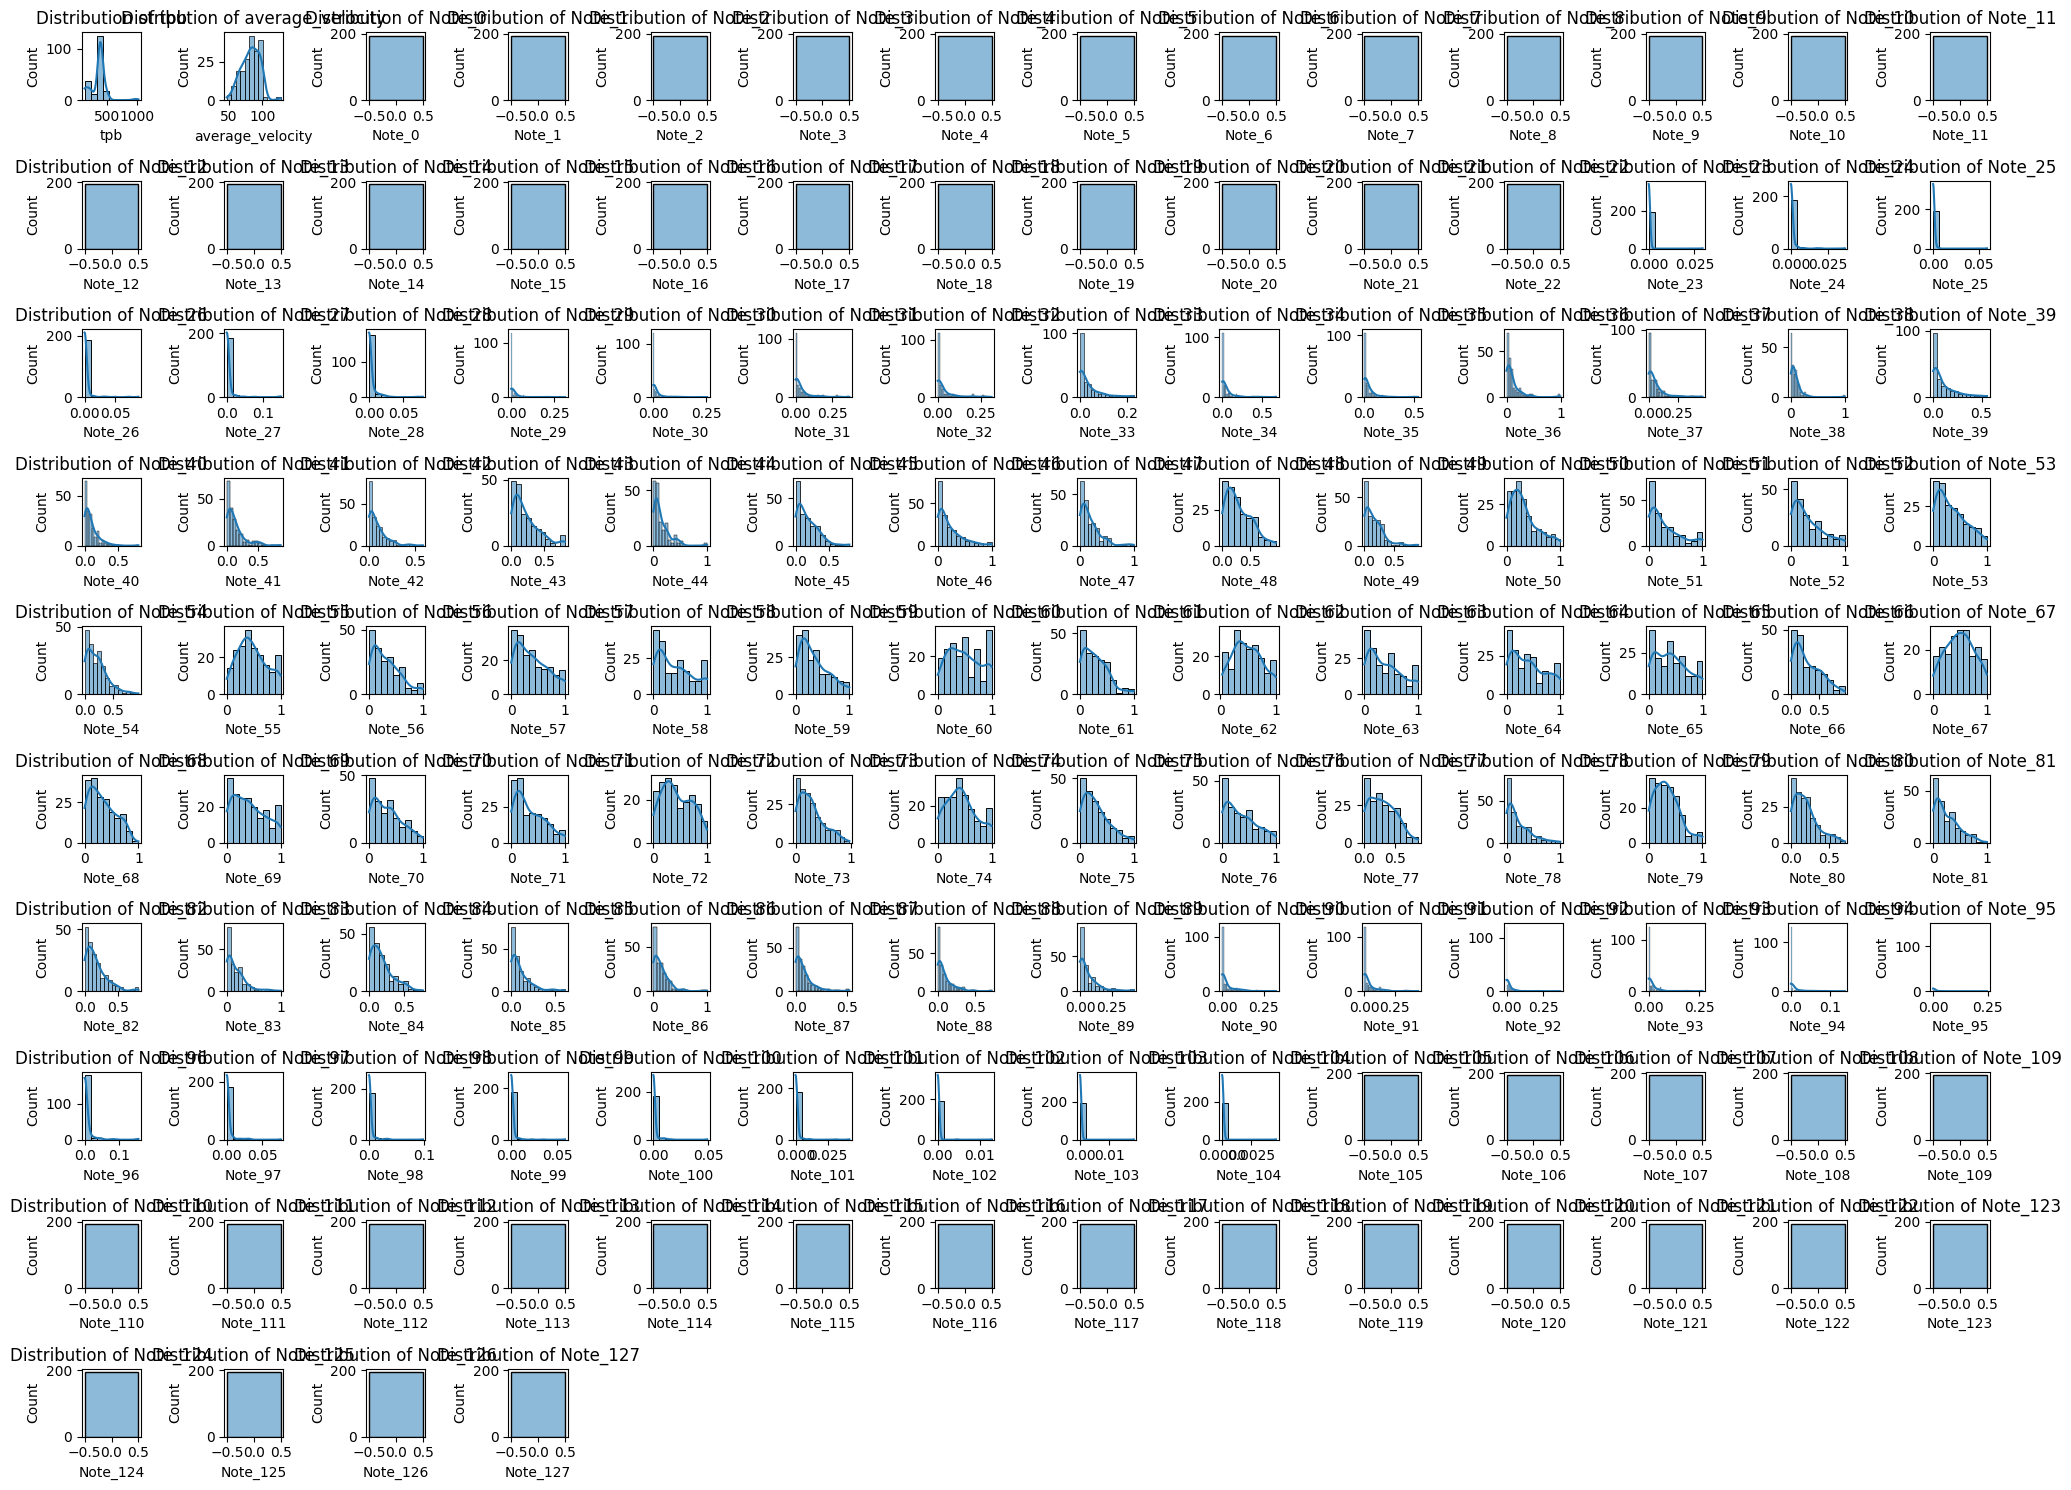

In [11]:
# Visualize the distribution of each numeric feature
numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

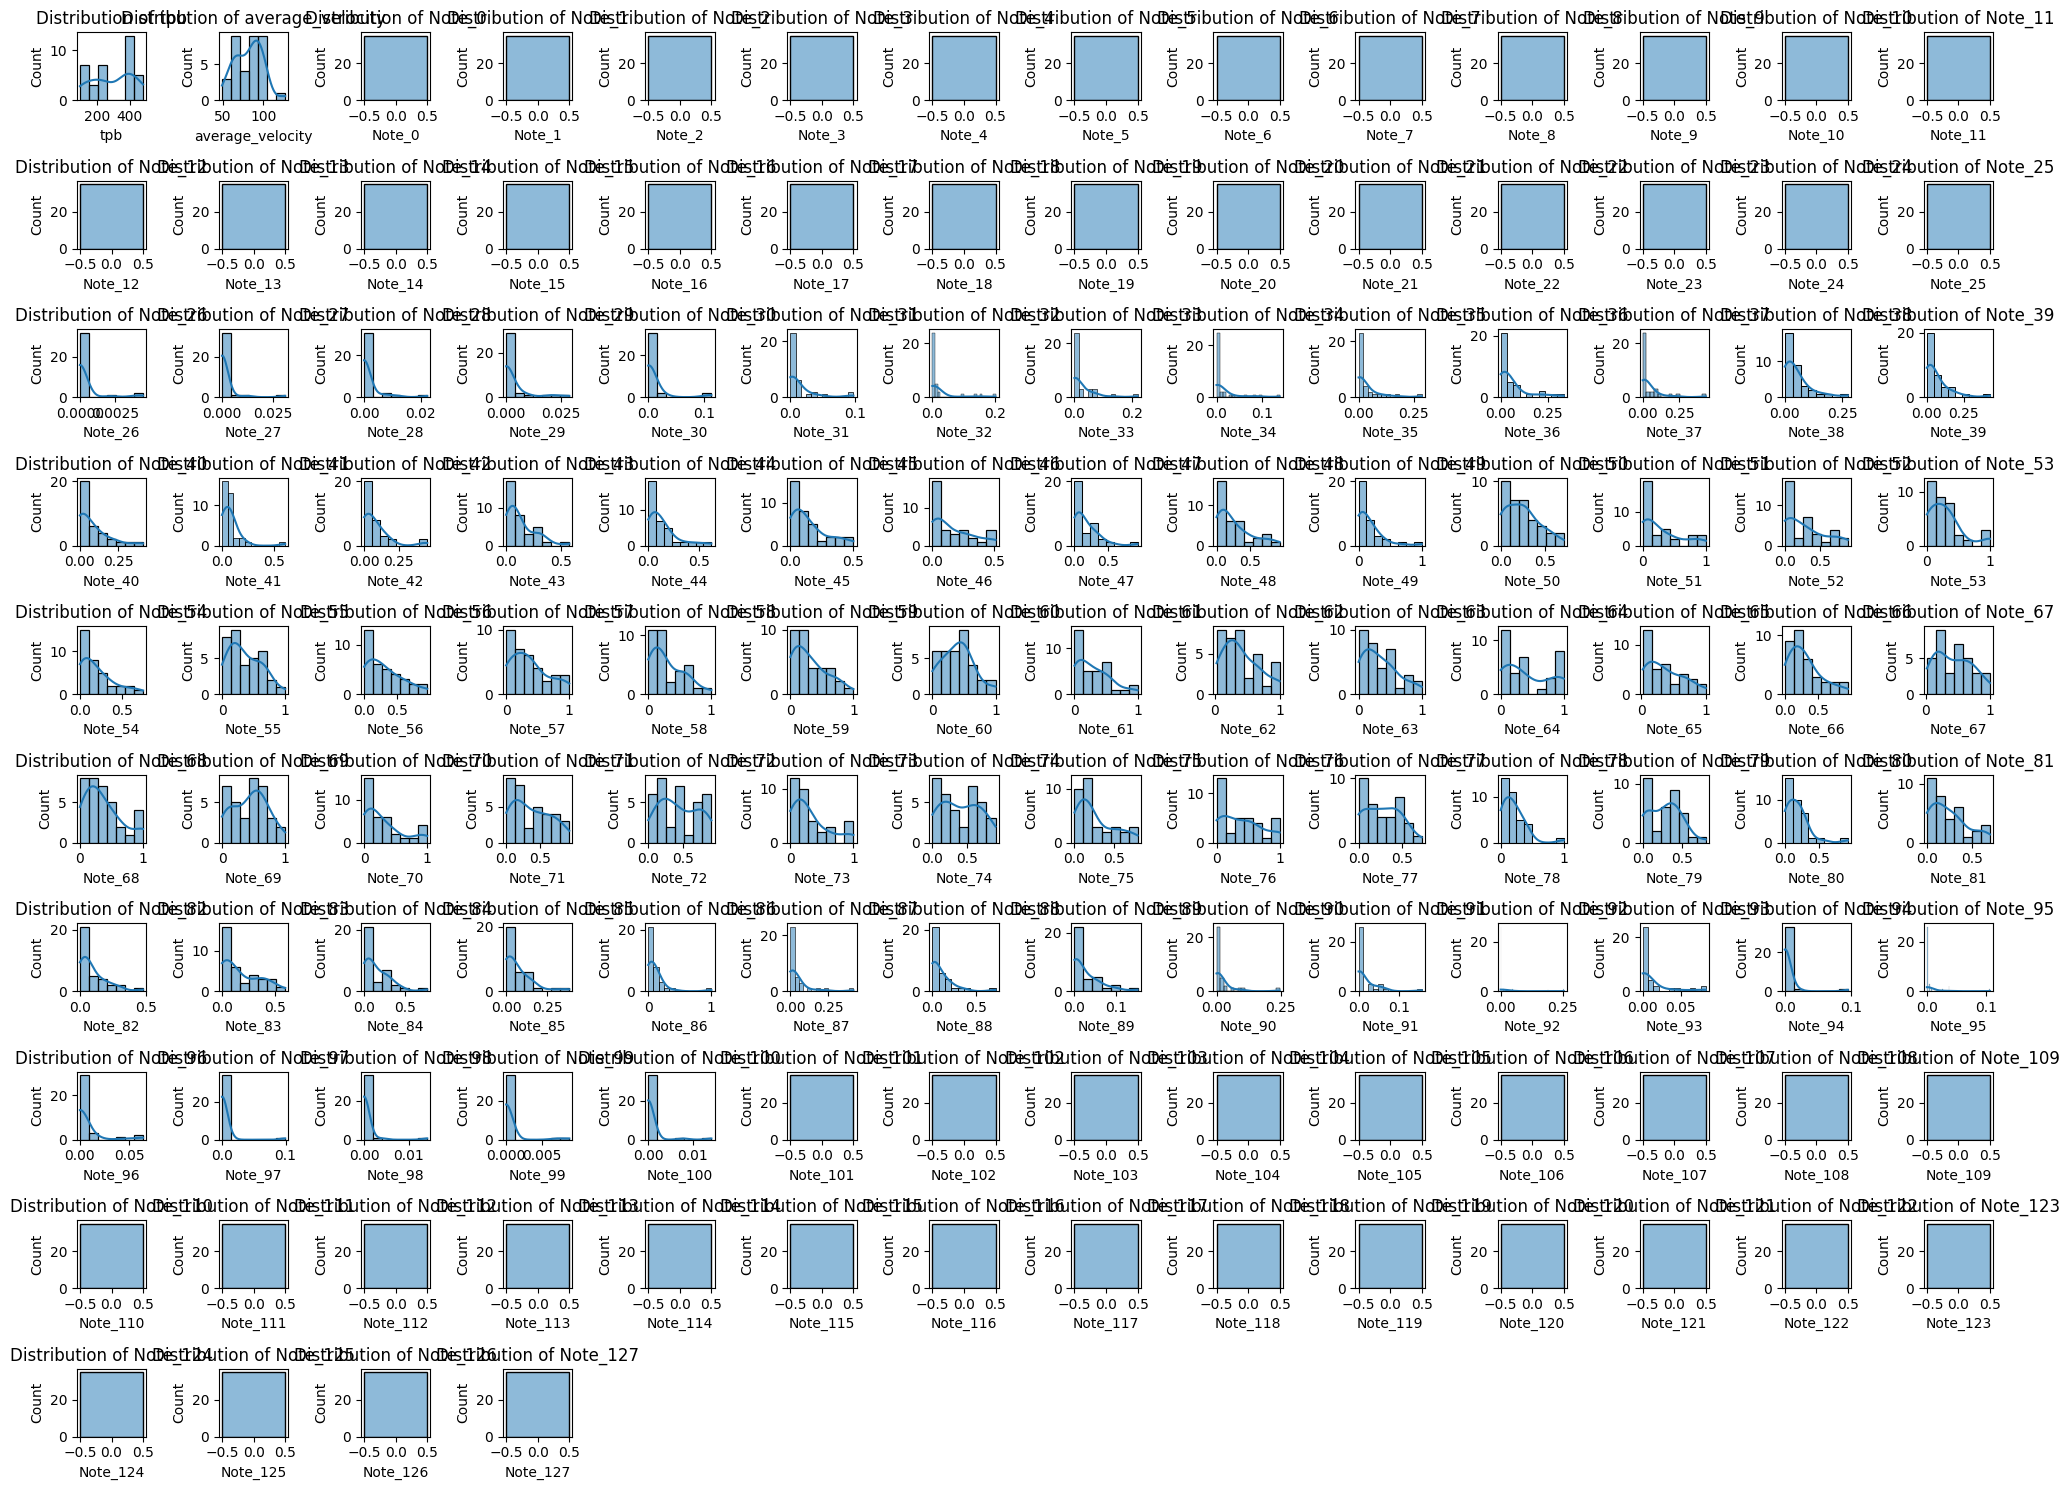

In [12]:
# Visualize the distribution of each numeric feature
numeric_columns = df_unlabeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_unlabeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

based on this, I'd remove notes 0-22, 105-127, unless we want to add back in for novelty detection

In [13]:
# Drop columns corresponding to notes 0-22 and 105-127
cols_to_drop = [f'Note_{i}' for i in list(range(0, 23)) + list(range(105, 128))]
df_labeled.drop(columns=cols_to_drop, inplace=True)

numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

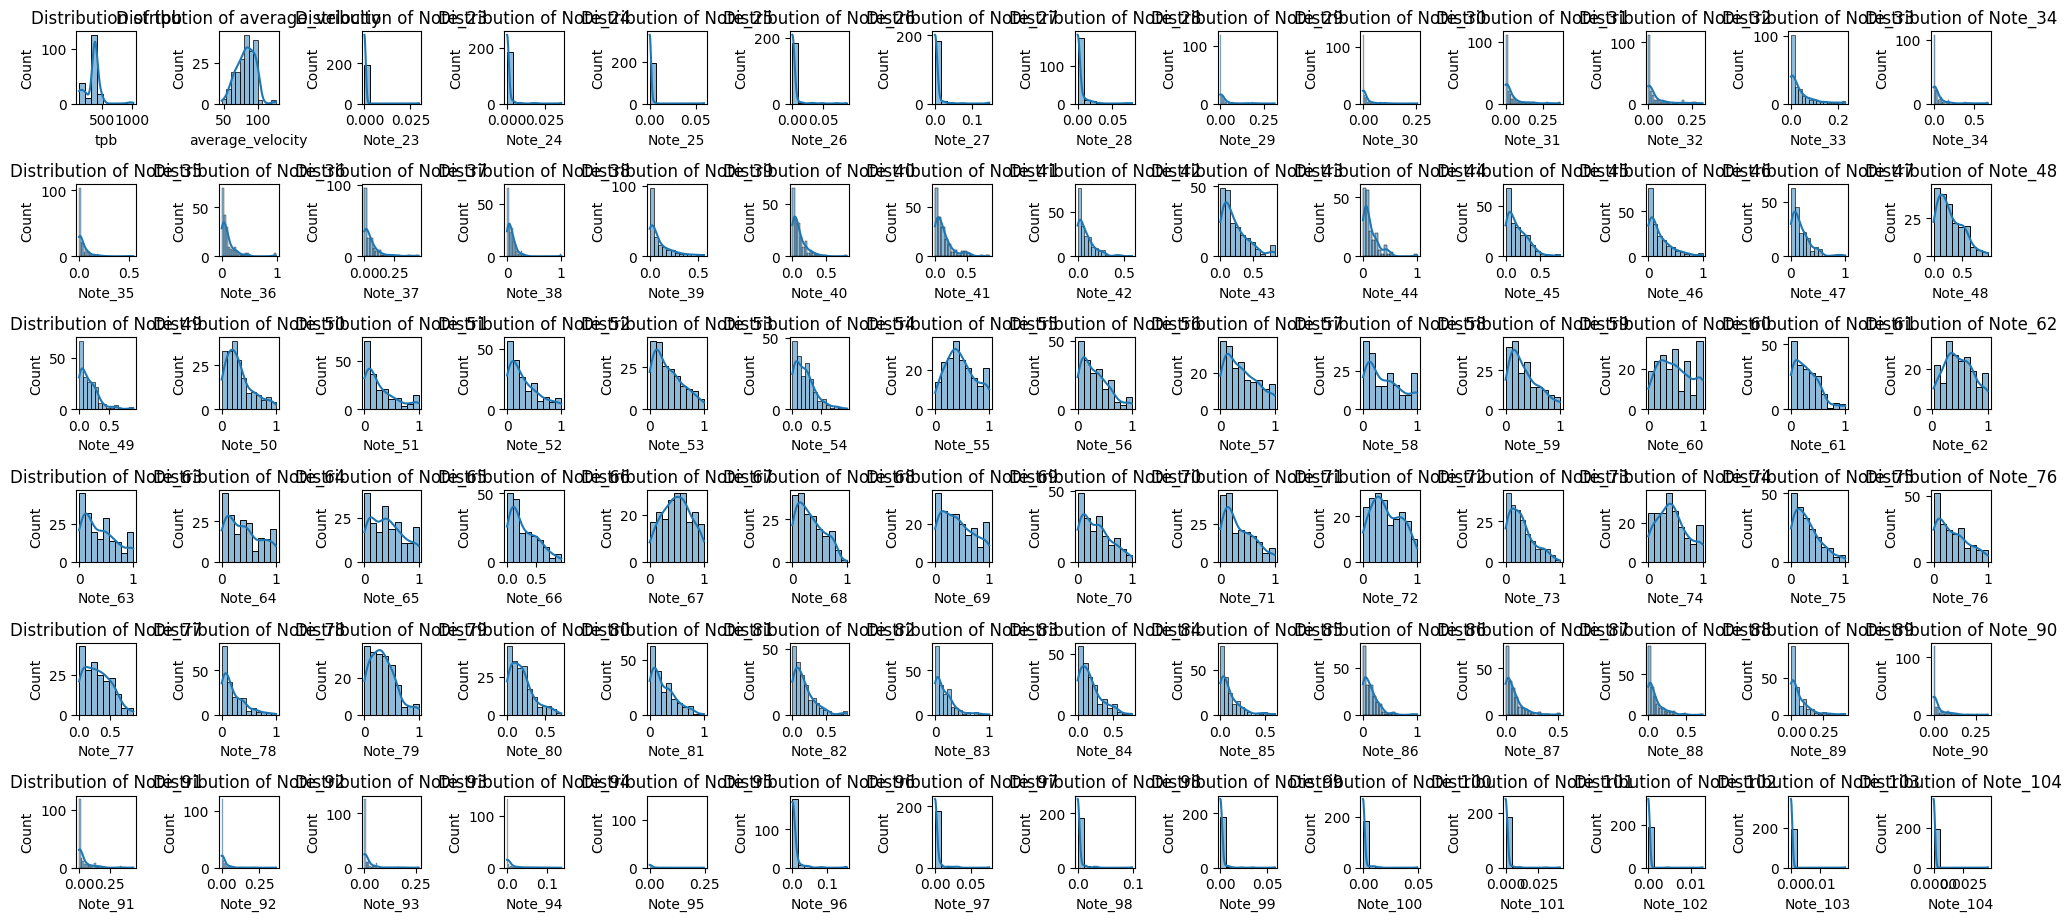

In [14]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

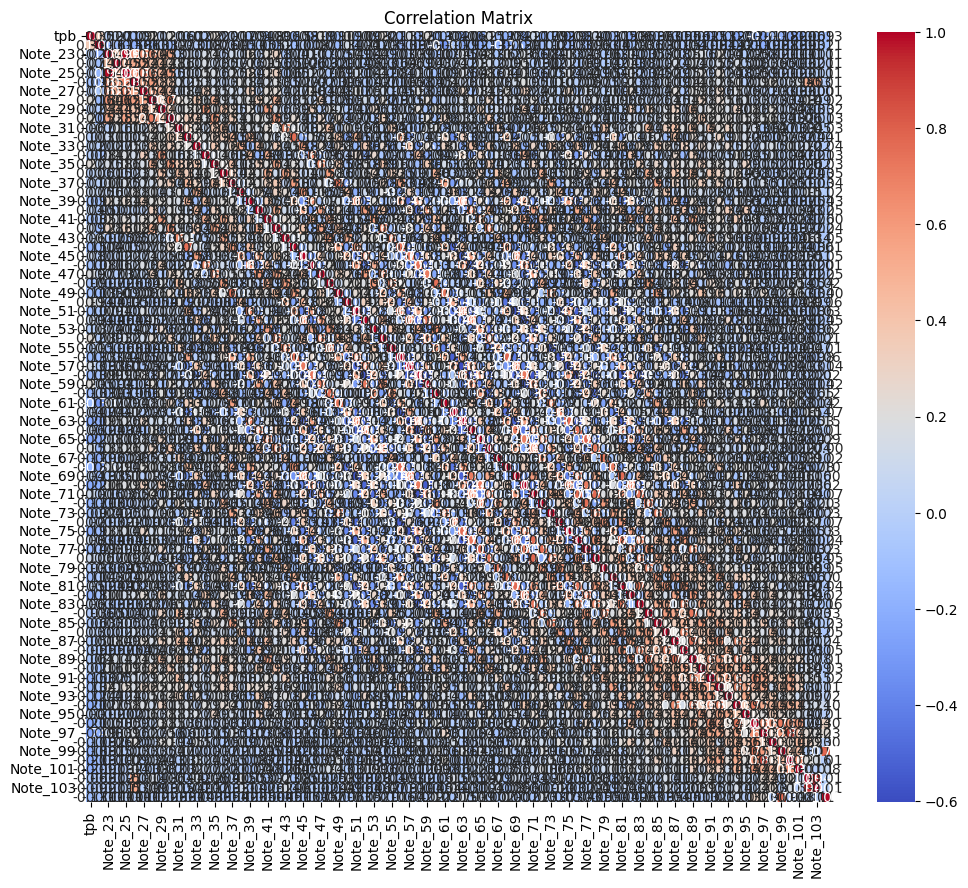

In [15]:
# Visualize correlations between numeric features
plt.figure(figsize=(12, 10))
correlation_matrix = df_labeled[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

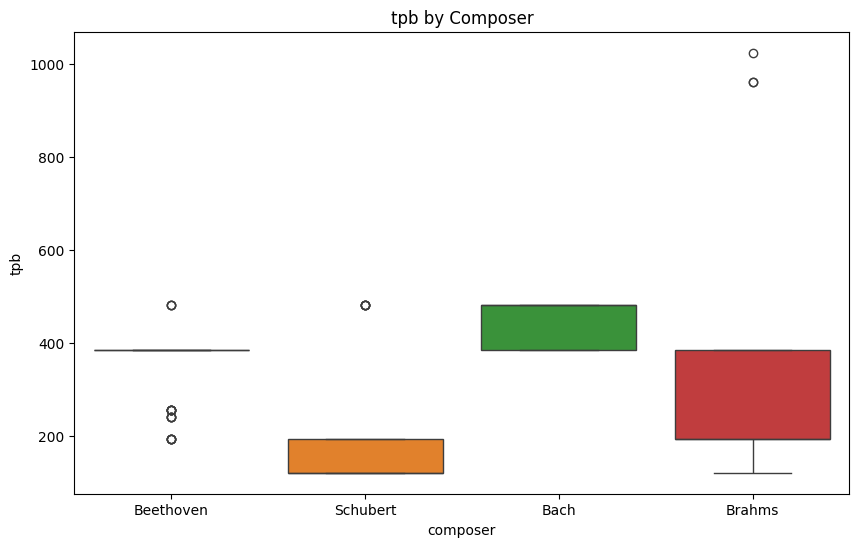

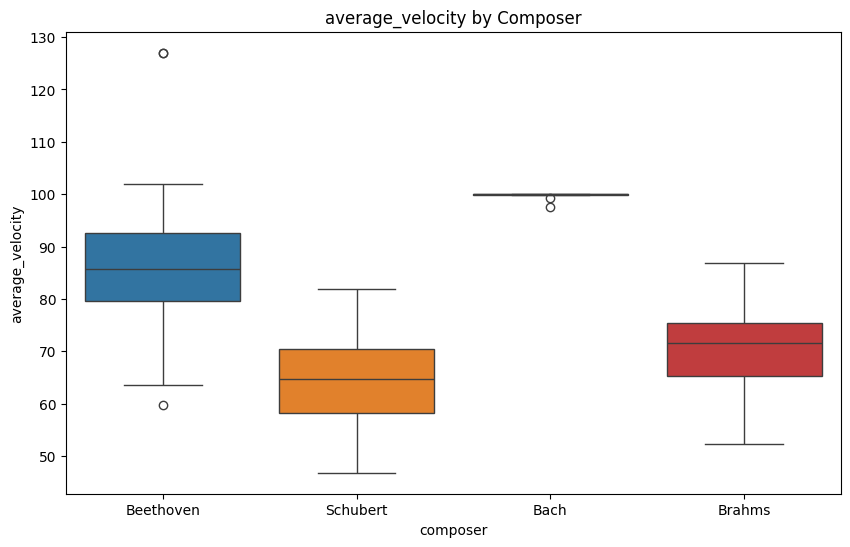

In [18]:
# Visualize the relationship between the first two numeric features and the target (if applicable)
if 'composer' in df_labeled.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='composer', y=numeric_columns[0], data=df_labeled, hue='composer')
    plt.title(f'{numeric_columns[0]} by Composer')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='composer', y=numeric_columns[1], data=df_labeled, hue='composer')
    plt.title(f'{numeric_columns[1]} by Composer')
    plt.show()

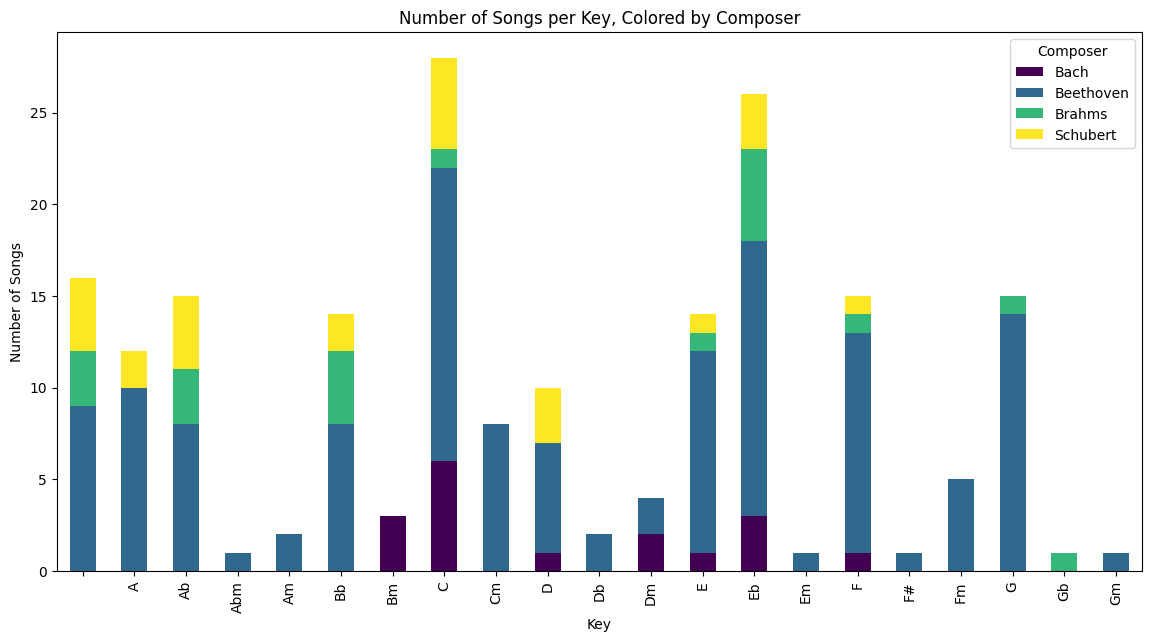

In [19]:
# Prepare the data for the stacked bar chart
key_composer_counts = df_labeled.groupby(['key', 'composer']).size().unstack(fill_value=0)
# Plot the stacked bar chart
key_composer_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Songs per Key, Colored by Composer')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.legend(title='Composer')
plt.show()


In [20]:
# # Generate the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(composer_avg, cmap='viridis', cbar=True)

# # Display the plot
# plt.title('Composer Note Values Heatmap')
# plt.xlabel('Notes')
# plt.ylabel('Composers')
# plt.show()

In [21]:
# # Transform the DataFrame into a long format
# df_long = pd.melt(composer_avg.reset_index(), id_vars=['Composer'], var_name='Note', value_name='Value')

# # Plot the bar chart
# plt.figure(figsize=(15, 8))
# sns.barplot(x='Note', y='Value', hue='Composer', data=df_long)

# # Customize the plot
# plt.title('Composer Note Values Bar Chart')
# plt.xlabel('Notes')
# plt.ylabel('Values')
# plt.legend(title='Composer')
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability

# # Display the plot
# plt.show()

## Clean + Feature engineer

In [22]:
# replace Null keys with 'unk' value
df_labeled['key']=df_labeled['key'].fillna('unk')

In [23]:
# Encode the 'key' variable
label_encoder_key = LabelEncoder()
df_labeled['key_encoded'] = label_encoder_key.fit_transform(df_labeled['key'])

In [24]:
# Encode the 'Composer' column
label_encoder_composer = LabelEncoder()
df_labeled['composer'] = label_encoder_composer.fit_transform(df_labeled['composer'])

In [25]:
# Define the features (X) and target (y)
X = df_labeled.drop(columns=['composer', 'key'])
y = df_labeled['composer']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [29]:
print(label_encoder_composer.classes_,'\n')
print('train targets\n',y_train.value_counts())
print('\ntest targets\n',y_test.value_counts())

['Bach' 'Beethoven' 'Brahms' 'Schubert'] 

train targets
 composer
1    77
3    16
2    15
0     8
Name: count, dtype: int64

test targets
 composer
1    55
3     9
0     9
2     5
Name: count, dtype: int64


## Train Classifier

### Logistic Regression

In [30]:
# Train and evaluate the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
# Get the classification probabilities for each class
y_proba_lr = log_reg.predict_proba(X_test)

/Users/bartmasters/code/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
y_proba_lr

array([[4.73819400e-04, 5.87955619e-01, 3.85535337e-02, 3.73017028e-01],
       [5.76363807e-01, 4.22496117e-01, 1.00008106e-03, 1.39994817e-04],
       [6.86389972e-07, 9.05386037e-02, 4.54761132e-02, 8.63984597e-01],
       [2.17099257e-03, 6.30241221e-01, 1.90902273e-01, 1.76685514e-01],
       [3.84947591e-04, 3.71359246e-01, 5.68207081e-01, 6.00487256e-02],
       [1.50397456e-06, 2.85668451e-02, 6.22078203e-02, 9.09223831e-01],
       [2.49395858e-02, 9.72165781e-01, 2.41105808e-03, 4.83575091e-04],
       [1.39156527e-02, 8.75588313e-01, 1.04361245e-01, 6.13478878e-03],
       [1.31346392e-05, 3.92948958e-01, 1.06751731e-01, 5.00286176e-01],
       [2.73034040e-03, 7.39266627e-01, 2.54996326e-01, 3.00670680e-03],
       [3.80108202e-06, 1.25762674e-01, 1.35845579e-01, 7.38387946e-01],
       [5.74935966e-02, 9.16320613e-01, 2.09677823e-02, 5.21800763e-03],
       [1.86182114e-01, 7.99583141e-01, 1.35974684e-02, 6.37276263e-04],
       [6.30741488e-03, 9.39814061e-01, 5.19099013e

In [32]:
print("Logistic Regression:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,))

# Print the classification probabilities along with the predicted class
print("\nLogistic Regression Classification Probabilities:")
for i, probs in enumerate(y_proba_lr):
    print(f"Sample {i}:")
    for j, class_prob in enumerate(probs):
        print(f"  Class {label_encoder_composer.classes_[j]}: {class_prob:.4f}")
    print(f"  Predicted Class: {label_encoder_composer.inverse_transform([y_pred_lr[i]])[0]}\n")

Logistic Regression:
Accuracy Score: 0.8333333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.88      0.93      0.90        55
           2       0.67      0.40      0.50         5
           3       0.64      0.78      0.70         9

    accuracy                           0.83        78
   macro avg       0.75      0.67      0.69        78
weighted avg       0.83      0.83      0.83        78


Logistic Regression Classification Probabilities:
Sample 0:
  Class Bach: 0.0005
  Class Beethoven: 0.5880
  Class Brahms: 0.0386
  Class Schubert: 0.3730
  Predicted Class: Beethoven

Sample 1:
  Class Bach: 0.5764
  Class Beethoven: 0.4225
  Class Brahms: 0.0010
  Class Schubert: 0.0001
  Predicted Class: Bach

Sample 2:
  Class Bach: 0.0000
  Class Beethoven: 0.0905
  Class Brahms: 0.0455
  Class Schubert: 0.8640
  Predicted Class: Schubert

Sample 3:
  Class Bach: 0.0022
  Cl

### Random Forest

In [34]:
# Build and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Predict the target on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Get the classification probabilities for each class
y_proba_rf = rf_classifier.predict_proba(X_test)

In [37]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Print the classification probabilities along with the predicted class
print("\nRF Classification Probabilities:")
for i, probs in enumerate(y_proba_rf):
    print(f"Sample {i}:")
    for j, class_prob in enumerate(probs):
        print(f"  Class {label_encoder_composer.classes_[j]}: {class_prob:.4f}")
    print(f"  Predicted Class: {label_encoder_composer.inverse_transform([y_pred_rf[i]])[0]}\n")

Accuracy Score: 0.8589743589743589

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.87      0.96      0.91        55
           2       1.00      0.20      0.33         5
           3       0.67      0.67      0.67         9

    accuracy                           0.86        78
   macro avg       0.88      0.65      0.70        78
weighted avg       0.87      0.86      0.84        78


RF Classification Probabilities:
Sample 0:
  Class Bach: 0.0800
  Class Beethoven: 0.2200
  Class Brahms: 0.1700
  Class Schubert: 0.5300
  Predicted Class: Schubert

Sample 1:
  Class Bach: 0.1500
  Class Beethoven: 0.7000
  Class Brahms: 0.1000
  Class Schubert: 0.0500
  Predicted Class: Beethoven

Sample 2:
  Class Bach: 0.0000
  Class Beethoven: 0.3900
  Class Brahms: 0.3100
  Class Schubert: 0.3000
  Predicted Class: Beethoven

Sample 3:
  Class Bach: 0.0100
  Class Beethoven: 0.5100
  Class Bra

## Inference

In [ ]:
def predict_composer(file_path, classifier):
    features = extract_features_from_midi(file_path)
    prediction = classifier.predict([features])
    return prediction[0]

# Example usage
new_midi_file = 'new_piece.mid'
composer = predict_composer(new_midi_file, clf)
print(f"The predicted composer is: {composer}")


# scratch

In [ ]:
file_path_ps2 = test_midi_path+"0.981087291054314_adj.mid"
file_path_ps1 = train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid"

In [ ]:
def exp_mido(file_path):
    midi = mido.MidiFile(file_path)
    print('Midi file type', midi.type)
    print('Length',midi.length)
    print('Ticks per beat',midi.ticks_per_beat)

    for i, track in enumerate(midi.tracks):
        print('Track {}: {}'.format(i, track.name))
        for msg in track:
            if msg.is_meta : #and msg.type == 'key_signature':
                # print(msg.key)
                print(msg)

In [ ]:
exp_mido(file_path_ps1)

In [ ]:
exp_mido(file_path_ps2)

In [ ]:
midi = mido.MidiFile(file_path)
print(midi.type)
print(midi.length)
print(midi.ticks_per_beat)

In [ ]:
for track in midi.tracks:
    for msg in track:
        print(track)
        print(msg)     

In [ ]:
for i, track in enumerate(midi.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        if msg.is_meta : #and msg.type == 'key_signature':
            # print(msg.key)
            print(msg)